<a href="https://colab.research.google.com/github/navavatpi/researchPhd/blob/developModeling/dataModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # https://pypi.python.org/pypi/pydot
# !apt-get -qq install -y graphviz && pip install pydot
# import pydot

# Template

## Environment Setup

In [2]:
# Enabling and testing the TPU
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.6.0
Running on TPU  ['10.22.182.90:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.22.182.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.22.182.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [12]:
# libraries import
import os
import numpy as np
from tensorflow import keras # back-end artificial neural network API
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam # optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving

# system configuration
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0" # disable warning messages
os.environ['AUTOGRAPH_VERBOSITY'] = '0' # set it to 0

random_seed = 20 # random seed

In [4]:
# connect to google drive to obtain dataset
# !note: need to perform authorization by following below link
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [5]:
# define path to files
defaultdir = '/content/drive/My Drive/all_about_phd/'

In [6]:
# load input data from drive
X_train = np.load(defaultdir + '/processed_data/X_train.npy')
X_test = np.load(defaultdir + '/processed_data/X_test.npy')
y_train = np.load(defaultdir + '/processed_data/y_train.npy')
y_test = np.load(defaultdir + '/processed_data/y_test.npy')

## Data Modeling

In [45]:
# define function to create CNN model
def cnnModel(data_train, num_classes, layer=1, x_filter= 64, 
             kernel_size= (3,3), pool_size=(2,2), drop_size=0.5, 
             ):
    
    # input layer convert arrays => tensors
    inputs = keras.Input(data_train.shape[1:]) # dimension of the input

    x1 = layers.Conv2D(filters = x_filter, 
                       kernel_size = kernel_size, 
                       padding = 'Same', 
                       activation ='relu')(inputs)
    x1 = layers.Conv2D(filters = x_filter, 
                       kernel_size = kernel_size, 
                       padding = 'Same', 
                       activation ='relu')(x1)
    x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
    x1 = layers.Dropout(drop_size)(x1)
    
    dense_size = x_filter
    
    if layer > 1:
        
        x1 = layers.Conv2D(filters = 2*x_filter, 
                           kernel_size = kernel_size, 
                           padding = 'Same', 
                           activation ='relu')(x1)
        x1 = layers.Conv2D(filters = 2*x_filter, 
                           kernel_size = kernel_size, 
                           padding = 'Same', 
                           activation ='relu')(x1)
        x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
        x1 = layers.Dropout(drop_size)(x1)
        
        dense_size = 2*x_filter
        
        if layer > 2:

            x1 = layers.Conv2D(filters = 4*x_filter, 
                               kernel_size = kernel_size, 
                               padding = 'Same', 
                               activation ='relu')(x1)
            x1 = layers.Conv2D(filters = 4*x_filter, 
                               kernel_size = kernel_size, 
                               padding = 'Same', 
                               activation ='relu')(x1)
            x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
            x1 = layers.Dropout(drop_size)(x1)
            
            dense_size = 4*x_filter
            
            if layer > 3:

                x1 = layers.Conv2D(filters = 8*x_filter, 
                                   kernel_size = kernel_size, 
                                   padding = 'Same', 
                                   activation ='relu')(x1)
                x1 = layers.Conv2D(filters = 8*x_filter, 
                                   kernel_size = kernel_size, 
                                   padding = 'Same', 
                                   activation ='relu')(x1)
                x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
                x1 = layers.Dropout(drop_size)(x1)
                
                dense_size = 8*x_filter
                
                if layer > 4:

                    x1 = layers.Conv2D(filters = 8*x_filter, 
                                       kernel_size = kernel_size, 
                                       padding = 'Same', 
                                       activation ='relu')(x1)
                    x1 = layers.Conv2D(filters = 8*x_filter, 
                                       kernel_size = kernel_size, 
                                       padding = 'Same', 
                                       activation ='relu')(x1)
                    x1 = layers.MaxPool2D(pool_size= pool_size)(x1)
                    x1 = layers.Dropout(drop_size)(x1)
                    
                    dense_size = 8*x_filter

    x2 = layers.Flatten()(x1)
    x2 = layers.Dense(dense_size, activation = "relu")(x2)

    outputs = layers.Dense(num_classes, activation= "softmax")(x2)

    cnnModel = keras.Model(inputs=inputs, outputs=outputs, name="CNN_model")

    cnnModel.summary()
    
    return cnnModel

In [48]:
# perform CNN model define function
cnnModel = cnnModel(X_train, layer=2, num_classes=3)

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 330, 640, 224)]   0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 330, 640, 64)      129088    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 330, 640, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 165, 320, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 165, 320, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 165, 320, 128)     73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 165, 320, 128)     14

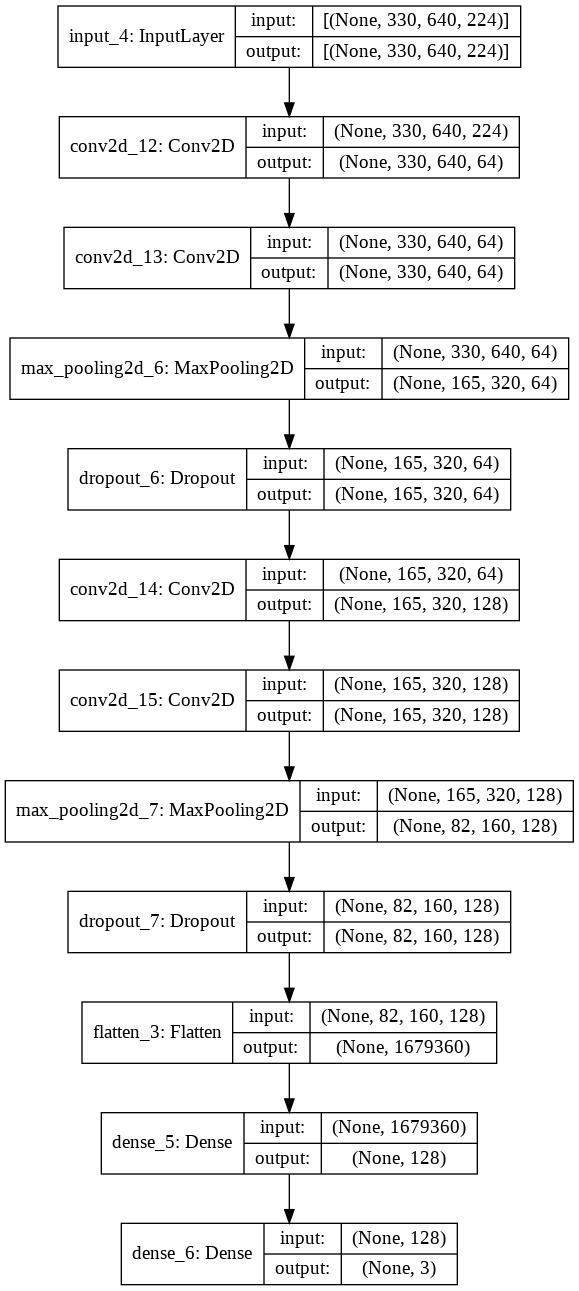

In [50]:
# plot CNN model architecture
# the figure will be saved in the same directory with input datas
tf.keras.utils.plot_model(cnnModel, 
                          to_file=defaultdir + '/processed_data/model.png', 
                          show_shapes=True)

In [53]:
# define ADAM opimizer & complie then train the model function
def modelFit(cnnModel, X_train, y_train, 
             X_test, y_test,
             epochs, batch_size, 
             learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
             epsilon=1e-08, decay=0):

  # Define the optimizer
  optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, 
                   epsilon=epsilon, decay=decay)

  # assign metrics for the model
  cnnModel.compile(optimizer=optimizer , 
                   loss="categorical_crossentropy", 
                   metrics=["accuracy"])

  # Set a learning rate annealer
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                          patience=3, 
                                          verbose=1, 
                                          factor=0.5, 
                                          min_lr=0.00001)

  # model training
  history = cnnModel.fit(X_train, y_train, 
                         batch_size=batch_size,
                         epochs = epochs, 
                         validation_data = (X_test,y_test),
                         verbose = 1, 
                         steps_per_epoch=X_train.shape[0]//batch_size,
                         callbacks=[learning_rate_reduction])


In [54]:
# perform compile function
modelFit(cnnModel=cnnModel, X_train=X_train, y_train=y_train, 
         X_test=X_test, y_test=y_test, 
         epochs=5, batch_size=5)

Epoch 1/5
3/3 [==============================] - 21s 8s/step - loss: 1.0946 - accuracy: 0.4000 - val_loss: 1.1169 - val_accuracy: 0.1667
Epoch 2/5
3/3 [==============================] - 11s 4s/step - loss: 1.0860 - accuracy: 0.4167 - val_loss: 1.1241 - val_accuracy: 0.1667
Epoch 3/5
3/3 [==============================] - 11s 4s/step - loss: 1.0616 - accuracy: 0.5000 - val_loss: 1.1369 - val_accuracy: 0.1667
Epoch 4/5
3/3 [==============================] - 11s 4s/step - loss: 1.1109 - accuracy: 0.3333 - val_loss: 1.1483 - val_accuracy: 0.1667

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 5/5
3/3 [==============================] - 13s 4s/step - loss: 1.0863 - accuracy: 0.4000 - val_loss: 1.1495 - val_accuracy: 0.1667


In [56]:
y_pred = cnnModel.predict(X_test)

In [57]:
y_pred

array([[0.4013772 , 0.28290638, 0.31571636],
       [0.4013772 , 0.28290638, 0.31571636],
       [0.4013772 , 0.28290638, 0.31571636],
       [0.4013772 , 0.28290638, 0.31571636],
       [0.4013772 , 0.28290638, 0.31571636],
       [0.4013772 , 0.28290638, 0.31571636]], dtype=float32)

In [58]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)